## U shape PHP dynamics with multiple liquid slugs - with heat transfer

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta$

In [1]:
@time using Plots
pyplot()

 20.611433 seconds (19.55 M allocations: 1.006 GiB, 3.82% gc time)


Plots.PyPlotBackend()

In [2]:
@time using DifferentialEquations

 65.260099 seconds (70.43 M allocations: 3.841 GiB, 3.12% gc time)


In [3]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing

cd(dirname(pwd()))

## Parameters of the PHP

In [4]:
    ω0 = [sqrt(1.2e004), sqrt(1.2e004)];
    ℘ = [1.2e005, 1.2e005];

    θinitial=1.0
    θ  = 0.15;
    θe = 1 + θ;
    θc = 1 - θ;
    
    He = 3000.0;
    Hc = 3000.0;
    Hₗ =  3000.0; # liquid wall heat transfer coeffcient

    
    X0 = 0.5;

    γ = 1.4;

In [5]:
    
    d = 1/30 # dimensionless diameter
    L = 8.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 


1.5707963267948966

## Pipe definition

In [6]:
tube = Tube(d,L,L2D,angle)

Tube(0.03333333333333333, 8.0, 2.0, 1.5707963267948966)

## Evaporator and condenser definition

In [7]:
Xe = map(tuple, [0.0; 3.0; 7.0], [1.0; 5.0; 8.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)])

In [8]:
Xc = map(tuple, [1.0; 5.0], [3.0; 7.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)])

## Vapor plug and liquid slug initialization

In [9]:
N=1000
X0 = [(0.5,2.5),(5.0,7.0)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
ρₗ = 1000
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(γ,Hₗ,ρₗ,ω0,℘,X0,dXdt0,Xarrays,θarrays)

Liquid(1.4, 3000.0, 1000.0, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 6.93574297188755, 6.943775100401607, 6.951807228915663, 6.959839357429719, 6.967871485943775, 6.975903614457831, 6.983935742971887, 6.991967871485944, 7.0]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  

In [10]:
P = [1.0,1.0,1.0];
δ = 0.05*P;
vapors=Vapor(γ,P,δ)

Vapor(1.4, [1.0, 1.0, 1.0], [0.05, 0.05, 0.05])

In [11]:
α = 1 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)

wall = Wall(α,Xwallarray,θwallarray)

Wall(1.0, [0.0, 0.008008008008008008, 0.016016016016016016, 0.024024024024024024, 0.03203203203203203, 0.04004004004004004, 0.04804804804804805, 0.056056056056056056, 0.06406406406406406, 0.07207207207207207  …  7.927927927927928, 7.935935935935936, 7.943943943943944, 7.951951951951952, 7.95995995995996, 7.967967967967968, 7.975975975975976, 7.983983983983984, 7.991991991991992, 8.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [12]:
# struct Mapping
#     walltoliquid::Array{Tuple{Int64,Int64},1}
#     liquidtowall::Array{Array{Int64,1},1}
# end

In [13]:
walltoliquid, liquidtowall = constructmapping(Xarrays,Xwallarray)
mapping = Mapping(walltoliquid,liquidtowall)

Mapping(Tuple{Int64,Int64}[(1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1)  …  (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1)], Array{Int64,1}[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73  …  305, 306, 307, 308, 309, 310, 311, 312, 313, 314], [626, 627, 628, 629, 630, 631, 632, 633, 634, 635  …  867, 868, 869, 870, 871, 872, 873, 874, 875, 876]])

## Construct the system

In [14]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping)

PHPSystem(Tube(0.03333333333333333, 8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), Liquid(1.4, 3000.0, 1000.0, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 

In [15]:
typeof(sys0)

PHPSystem

## Construct U for wall heat function

## construct state vector U

In [16]:
sys0.wall.θarray = settemperature!.(sys0.wall.θarray,sys0.wall.Xarray,[sys0]);

In [17]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L)
M = P.^(1/γ).* Lvaporplug


u=[XMtovec(X0,dXdt0,M); wallθtovec(sys0.wall.θarray); liquidθtovec(sys0.liquid.θarrays)];

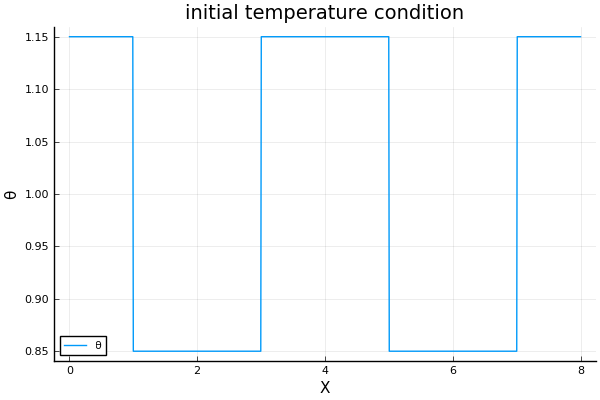

In [18]:
plot([sys0.wall.Xarray],[sys0.wall.θarray], title="initial temperature condition", labels = "θ", xlabel="X", ylabel="θ")

## Solve the constructed ODE for U

### propagation function

In [19]:
function dfdt(u,p,t)
    
    sys = deepcopy(getcurrentsys(u,p))
    
        indexes = Int64[]
        θliquidtemp = Array[]

        for i = 1:length(u)
            if abs(u[i]+1e10) <= 10^(-1)
                push!(indexes,i)
            end
        end
    

    dynamicsdu = dynamicsmodel(u[1:indexes[1]-1],sys)
    
    
    
    duwalltemp = wallmodel(u[indexes[1]+1:indexes[2]-1],sys)
    walldu = duwallθtovec(duwalltemp)
    
    
    
    for i = 1:length(indexes)-2
    push!(θliquidtemp, u[indexes[i+1]+1:indexes[i+2]-1])
    end
    push!(θliquidtemp, u[indexes[end]+1:end])
    
    
    duliquidtemp = zero.(deepcopy(θliquidtemp))
    duliquidtemp = liquidmodel(θliquidtemp,sys)
    liquiddu = duliquidθtovec(duliquidtemp)
    
    du = [dynamicsdu;walldu;liquiddu]
    
    return(du)

end

dfdt (generic function with 1 method)

### condition

In [20]:
# function condition(u,t,integrator)
#     false
# end

### affect! (with boundary conditions)

In [21]:
# function affect!(integrator)
#     θᵣtemp = deepcopy(integrator.u)
    
#     θᵣtemp = settemperature!.(θᵣtemp,x,[sys0])
    
#     set_u!(integrator,  θᵣtemp)
# end

In [22]:
# cb = DiscreteCallback(condition,affect!)

In [23]:
tstep=4e-5

p = sys0
tspan = (0.0, 0.2);
prob = ODEProblem(dfdt, u, tspan, p)

# integrator = init(prob, RK4(), adaptive=false, dt=tstep );
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
# sol = solve(prob, RK4(), adaptive=false, dt=tstep, callback=cb, save_everystep=true);

In [24]:
constructmapping(Xarrays,Xwallarray)

(Tuple{Int64,Int64}[(1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1), (1, -1)  …  (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1), (3, -1)], Array{Int64,1}[[79, 80, 81, 82, 83, 84, 85, 86, 87, 88  …  319, 320, 321, 322, 323, 324, 325, 326, 327, 328], [618, 619, 620, 621, 622, 623, 624, 625, 626, 627  …  859, 860, 861, 862, 863, 864, 865, 866, 867, 868]])

In [25]:
result1=soltoMatrxResult(sol,sys0);

In [26]:
@gif for i=1:size(sol,2)
plot([x],[sol[i][13:1012]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along the wall"), ylim=(0.85,1.15))
    vline!([0,1,3,5,7,8], color = [:red])
    end every 50

UndefVarError: UndefVarError: x not defined

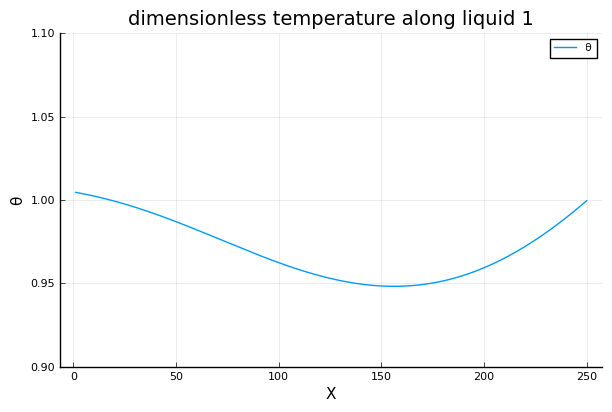

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\OneDThermalFlow\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\ninUP\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\OneDThermalFlow\\tmp.gif")
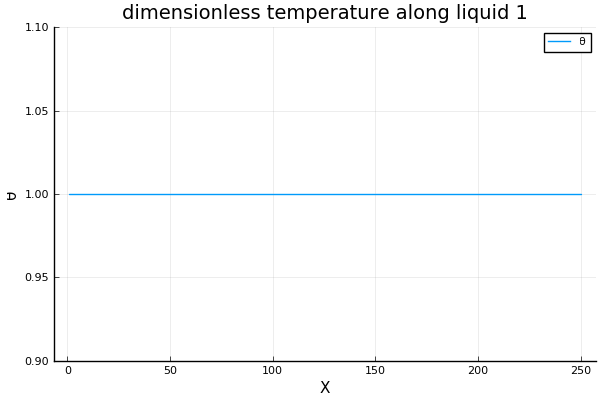

In [27]:
@gif for i=1:size(sol,2)
plot([sol[i][1014:1263]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along liquid 1"), ylim=(0.9,1.1))
    end every 50

In [28]:
MatrxXp, MatrxdXdt, MatrxM=soltoMatrxResult(sol,sys0);

ΔMatrxXp = zeros(size(MatrxXp,1)+1,size(MatrxXp,2))
ΔMatrxXp[1,:] = MatrxXp[1,:]
ΔMatrxXp[end,:] .= sys0.tube.L .- MatrxXp[end,:]
for i = 2:size(MatrxXp,1)
    ΔMatrxXp[i,:] = MatrxXp[i,:]-MatrxXp[i-1,:]
end


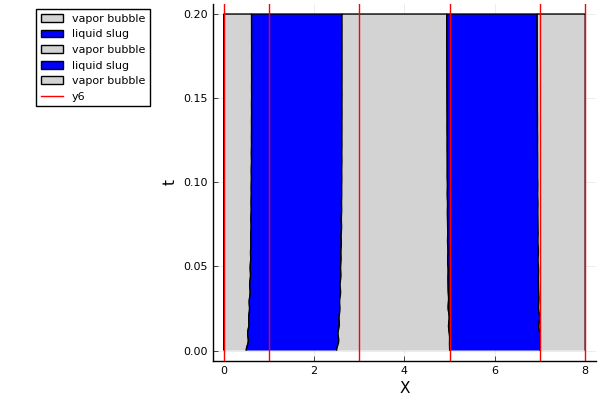

In [29]:
portfoliocomposition(ΔMatrxXp', sol.t, legend = :outertopleft, color = [:lightgrey :blue],ylabel="t", xlabel="X", labels = ["vapor bubble" "liquid slug"])
vline!([0,1,3,5,7,8], color = [:red])

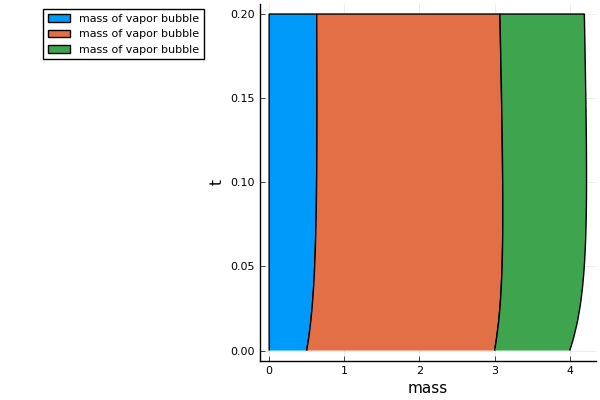

In [30]:
portfoliocomposition(MatrxM', sol.t, legend = :outertopleft, labels = ("mass of vapor bubble"), ylabel="t", xlabel="mass")

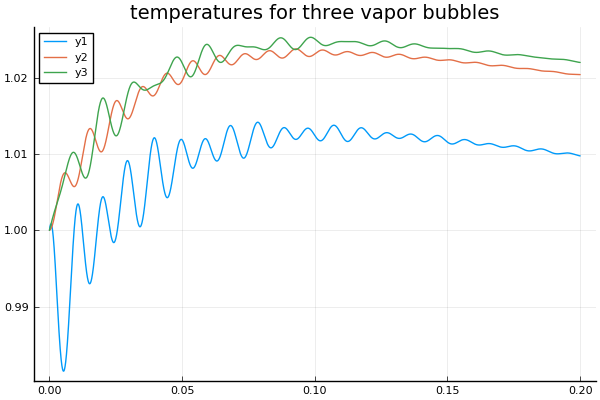

In [31]:
result1 = soltoResult(sol[1:11,:],sys0)
plot(sol.t, result1.θ[1], title="temperatures for three vapor bubbles")
plot!(sol.t, result1.θ[2])
plot!(sol.t, result1.θ[3])

In [51]:
Xvapornew = (0.51,0.52)

getinsertindex(Xp,Xvapornew)

1

In [49]:
function getinsertindex(Xp,Xvapornew)

for index = 1:length(Xp)
    if Xp[index][1] <= Xvapornew[1] && Xp[index][2] >= Xvapornew[2]
        return index
end
    end
        return NaN
end

getinsertindex (generic function with 1 method)

In [ ]:
function insertXvapor!(Xp,dXdt,Xvapornew)
    
    index = getinsertindex(Xp,Xvapornew)
    
    
    
end

In [38]:
function newvaporbubble(sys)
    Xp = sys.liquid.Xp
    dXdt = sys.liquid.dXdt
    P = sys.vapor.P
    
    Lvaporplug = XptoLvaporplug(X0,sys.tube.L)
    M = P.^(1/γ).* Lvaporplug

    δ = sys.vapor.δ
end

newvaporbubble (generic function with 1 method)